----------------------------------------------
breast-cancer.csv
supervised NB accuracy: 0.758741
supervised cross validation: 0.734606


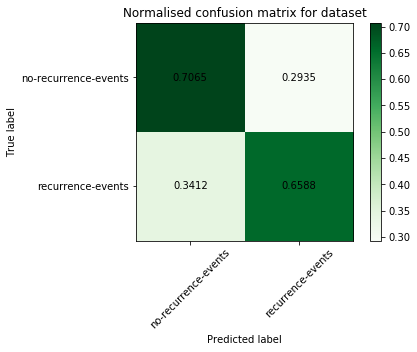

unsupervised accuracy (from confusion matrix): 0.702797
unsupervised NB accuracy: 0.692308
deterministic supervised accuracy: 0.657343

----------------------------------------------
car.csv
supervised NB accuracy: 0.873843
supervised cross validation: 0.732514


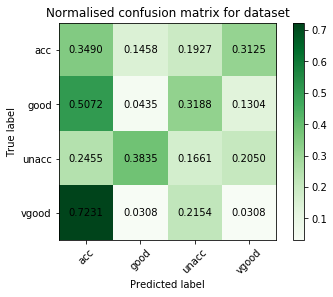

unsupervised accuracy (from confusion matrix): 0.700231
unsupervised NB accuracy: 0.196759
deterministic supervised accuracy: 0.304398

----------------------------------------------
hypothyroid.csv
supervised NB accuracy: 0.952261
supervised cross validation: 0.952366


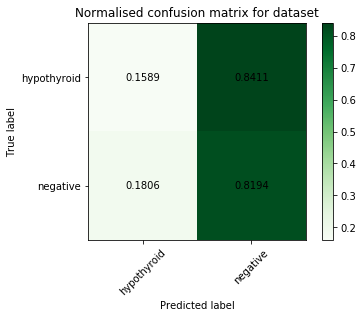

unsupervised accuracy (from confusion matrix): 0.952261
unsupervised NB accuracy: 0.787860
deterministic supervised accuracy: 0.517547

----------------------------------------------
mushroom.csv
supervised NB accuracy: 0.995815
supervised cross validation: 0.993473


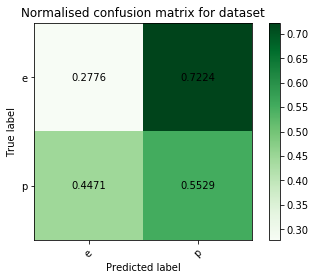

unsupervised accuracy (from confusion matrix): 0.589734
unsupervised NB accuracy: 0.410266
deterministic supervised accuracy: 0.525357

----------------------------------------------


In [14]:
# Project 1: Supervised and unsupervised Naive Bayes classifiers
# Subject: COMP30027 Machine Learning, 2018 Semester 1
# Authors: Bilal Sheheta and Armaan Dhaliwal-McLeod

# all script imports below
import os
import numpy as np
import matplotlib.pyplot as plt

from csv import reader
from random import choice
from pprint import pprint
from itertools import chain
from operator import itemgetter
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
from sklearn.metrics import confusion_matrix

def preprocess(filename):
    """Opens dataset and transforms it into a usable format. The format given
    back is 2D list of strings, where each list is a row in the file. When
    this 2D is created. Returns this data in a cleaned format. 
    
    Args:
        filename (str): dataset
    
    Returns:
        list: 2D list of strings
    """

    # all lines in file go here
    lines = []

    # open file
    with open(filename) as infile:

        # convert to reader object
        csv_reader = reader(infile)

        # loop over each line and add it to resultant list
        for line in csv_reader:
            lines.append(line)

    # return cleaned csv data
    return clean(lines)

def clean(training_data):
    """Cleans training data by replacing '?' attributes with most common item
    in column. It first transposes the data, imputes the missing data, then
    re-transposes it into its original structure. Returns this new structure. 
    
    Args:
        training_data (list): training data contained in 2D list of strings 
    
    Returns:
        list: 2D list of strings
    """

    cleansed_data = []

    # transpose training data for imputation
    # make columns rows instead for easier access and manipulation
    for column in zip(*training_data):

        # count elements in each column
        # remove '?' character from counts
        # get most common item in column
        counts = Counter(column)
        counts.pop('?', None)
        common = counts.most_common(1)[0][0]

        # imputate invalid data with max occuring data in column
        new_column = [common if val == '?' else val for val in column]
        cleansed_data.append(new_column)

    # transpose modified data back into rows
    return list(map(list, zip(*cleansed_data)))

def train_supervised(training_data):
    """Trains a supervised NB model. Counts and probabilites are calculated
    from the training data and used to build this model. Returns dictionaries 
    containing the prior and posterier counts.
    
    Args:
        training_data (list): training data contained in 2D list of strings 
    
    Returns:
        (collections.defaultdict, collections.defaultdict): 
    """
    # priors count dictionary
    priors = defaultdict(int)

    # count prior probabilities
    for line in training_data:
        col = line[-1]
        priors[col] += 1/len(training_data)

    # create posteriers data structure with triple nested defaultdicts
    # perhaps a more simplified data structure could be used here
    # initialising int here initially for storing frequencies
    # initialise frequency to 1 for smoothing
    posteriers = defaultdict(lambda : defaultdict(lambda : defaultdict(int)))

    # Loop over each line in preprocessed training data
    for line in training_data:

        # obtain class and attributes
        attributes, class_name = line[:-1], line[-1]

        # count each item
        # using indices as attribute headers since not given in dataset
        # indice starts at one
        # perhaps datasets could be modified to include header names
        for attribute, freq in enumerate(attributes):
            posteriers[class_name][attribute][freq] += 1

    # transform posteriers counts into probabilities
    for class_name in posteriers:
        for attribute in posteriers[class_name]:

            # sum counts over each dict
            # This will be the same accross each class
            sums = sum(posteriers[class_name][attribute].values())

            # update to probabilites by dividing freq/sums
            for freq in posteriers[class_name][attribute]:
                posteriers[class_name][attribute][freq] /= sums

    # return a tuple of the two above data structures
    return priors, posteriers

def predict_supervised(priors, posteriers, instance):
    """Predicts instances of NB supervised model by predicting an instence from
    the training data. Uses the priors and posteriers from the trained model,
    and needs an instance to predict. returns predicted class of specified
    instance.
    
    Args:
        priors (collections.defaultdict): priors count dictionary
        posteriers (collections.defaultdict): posteriers count dictionary
        instance (list): instance row to predict
    
    Returns:
        str: Predicted class
    """
    # epsilon value for smoothing
    EPSILON = 0.000000000001

    # dictionary holding maximal for each class
    class_max = {}

    for class_name in posteriers:
        product = 1

        # go over attributes of the trained data and instances at once
        # get the hashed probability
        for attribute, value in zip(posteriers[class_name], instance):
            prob = posteriers[class_name][attribute][value]

            # if probability is non-zero, accumulate it
            # otherwise, accumulate the smoothing factor
            if prob:
                product *= prob
            else:
                product *= EPSILON

        class_max[class_name] = product * priors[class_name]

    # return a tuple of the class and maximal probability
    return max(class_max.items(), key=itemgetter(1))

def evaluate_supervised(priors, posteriers, training_data):
    """Evaluate trained supervised NB model, where each instance is compared 
    with its corresponding predicted class. Returns number of correct 
    predictions divided by number of instances in training data.
    
    Args:
        priors (collections.defaultdict): priors count dictionary
        posteriers (collections.defaultdict): posteriers count dictionary
        training_data (list): training data contained in 2D list of strings 
    
    Returns:
        float: evaluation metric
    """

    # keep a counter of correct instances found
    correct = 0

    # go over each instance in data set
    # get predicted class for each instance
    for instance in training_data:
        predict_class, _ = predict_supervised(priors, posteriers, instance)

        # if class is identical to the instances last column
        # increment the count
        if predict_class == instance[-1]:
            correct += 1

    return correct/len(training_data)

def cross_validation(data, k):
    """Performs cross validation on a dataset. splits dataset into k partitions,
    then chooses one section to be the training data, and the rest as the test
    data. This is performed k times. Returns new accuracy. 
    
    Args:
        data (list): data contained in 2D list of strings 
        k (int): Number of partitions for data to be splitted into
    
    Returns:
        float: sum of evaluations for each test data divided by k
    """
    # divide dataset into k length partitions
    partitions = [part.tolist() for part in np.array_split(data, k)]

    # helper function for flattening a list
    flatten = lambda lst : list(chain.from_iterable(lst))

    # accuracy counter
    sums = 0

    for i, test_data in enumerate(partitions):

        # get every other partition except current test data
        # flattens each section to concatenate lists nicely
        training_data = flatten(partitions[:i]) + flatten(partitions[i+1:])

        # get the trained supervised model
        priors, posteriers = train_supervised(training_data)

        # accumulate accuracy of test data
        sums += evaluate_supervised(priors, posteriers, test_data)

    return sums/k

def construct_posteriers_unsupervised(priors, distributions, training_data):
    """Constructs a new posterier dictionary for a unsupervised model. This is
    is geared for updating the posterier dictionary after each iteration with
    new probabilities. Returns fresh dictionary with new probabilities. 
    
    Args:
        priors (collections.defaultdict): priors count dictionary
        distributions (list): list of dictionary for class distributions
        training_data (TYPE): 2D list containing instances from training data
    
    Returns:
        collections.defaultdict: New posterier dictionary
    """
    # new posteriers
    posteriers = defaultdict(lambda : defaultdict(lambda : defaultdict(float)))

    # convert fractional counts to probabilities
    for instance, dist_dict in zip(training_data, distributions):
        for class_name, dist in dist_dict.items():
            for attribute, value in enumerate(instance):
                posteriers[class_name][attribute][value] += (dist / 
                                                            priors[class_name])

    return posteriers

def deterministic_unsupervised(training_data, classes):
    """Deterministically assigns classes to each instance in a supervised NB
    model. Simply removes the last column containing the class, and replaces it
    with a random class. Returns new training data. 
    
    Args:
        training_data (list): 2D list of lists containing training data
        classes (list): list containing names of classes
    
    Returns:
        list: 2D list of lists containing new data
    """

    return [instance[:-1] + [choice(classes)] for instance in training_data]

def train_unsupervised(training_data):
    """Trains a unsupervised NB model. Very similar to supervised NB, except
    random distributions for each class are generated. 
    
    Args:
        training_data (list): 2D list of lists containing training data
    
    Returns:
        (collections.defaultdict, collections.defaultdict, list, list, list)
    """
    # get sorted list of classes in data set
    # allowed columns of classes to always be same order
    classes = sorted(set(map(itemgetter(-1), training_data)))

    # strip classes from training data
    # also clean training data
    classless_training = [instance[:-1] for instance in training_data]

    # random_distributions
    distributions = []

    # priors of distribution counts
    priors = defaultdict(float)

    # calculate priors of random distribtions
    # and transform training data into randomized labelled data
    for instance in classless_training:
        rand_distribution = np.random.dirichlet(np.ones(len(classes)), size=1)
        
        # add and create tupled pairs of (class, distribution)
        # add as a ordered dictionary to keep ordering of classes
        class_distribution = list(zip(classes, *rand_distribution))
        distributions.append(OrderedDict(class_distribution))

        # fraction prior counts
        for class_name, dist in class_distribution:
            priors[class_name] += dist

    # transform into posterier probability dictionary
    posteriers = construct_posteriers_unsupervised(priors, 
                                                   distributions, 
                                                   classless_training)

    # return a tuple of all the needed data structures
    return priors, posteriers, distributions, classless_training, classes

def predict_unsupervised(priors, posteriers, distributions, training_data):
    """Predicts unsupervised NB nodel. Each time called, new postieriers and
    distributions are created in order to generate new predictions each
    iteration. 
    
    Args:
        priors (collections.defaultdict): priors counting dictionary
        posteriers (collections.defaultdict): posteriers counting dictionary
        distributions (list): list containing class distributions
        training_data (list): 2D list of lists containing training data
    
    Returns:
        (collections.defaultdict, list): tuple containing new posteriers and
        distributions.
    """

    # convert fractions to probabilities
    probs = {cs: cnt / len(training_data) for cs, cnt in priors.items()}

    # go over each instance and distribution sumultaneously
    # collect new distributions
    for instance, distribution in zip(training_data, distributions):
        new_dists = []

        # go over each class in distribution
        for class_name in distribution:
            product = 1

            # calculate new distributions
            for attribute, value in enumerate(instance):
                product *= posteriers[class_name][attribute][value]

            # multiply by probability and add it
            product *= probs[class_name]
            new_dists.append(product)

        # normalise distribution into probabilities
        for class_name, new_dist in zip(distribution, new_dists):
            distribution[class_name] = new_dist / sum(new_dists)

    # recreate posteriers with new distributions
    new_posteriers = construct_posteriers_unsupervised(priors, 
                                                       distributions, 
                                                       training_data)

    return new_posteriers, distributions

def output_confusion_matrix(matches, guesses, classes):
    """Returns a confusion matrix based on the actual classes vs the predicted
    classes.
    
    Args:
        matches (list): actual classes
        guesses (list): predictions
        classes (list): All possible classes
    
    Returns:
        sklearn.metrics.confusion_matrix: Confusion matrix
    """

    # create confusion matrix
    cm = confusion_matrix(matches, guesses, labels=classes)
    
    # calculate a the accuracy using confusion matrix
    # this requires transposing the matrix
    # and totalling the max item over the sum
    correct_guesses = 0
    total_sum = 0
    for row in cm.transpose():
        correct_guesses += max(row)
        total_sum += sum(row)

    # output the confusion accuracy

    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm,cmap= plt.cm.Greens)

    # set axis
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # get dimensions of matrix
    width, height = cm.shape

    # annotate matrix with correct decimal places
    for x in range(width):
        for y in range(height):
            plt.annotate('%.4f' % cm[x][y], xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center') 

    # create labels and show matrix
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalised confusion matrix for dataset')
    plt.show()
    
    print('unsupervised accuracy (from confusion matrix): %f' % (correct_guesses/total_sum))
    # return actual matrix
    return cm
    
def evaluate_unsupervised(distributions, training_data, classes):
    """Evaluate trained unsupervised model, where each instance is compared with 
    its corresponding predicted class. Returns number of correct predictions
    divided by number of instances in training data. Also outputs a confusion
    matrix, along with its evauluated accuracy.
    
    Args:
        distributions (list): list of class distributions for each instance
        training_data (list): 2D list of lists containing training data
        classes (list): All possible classes
    
    Returns:
        float: Evaluation metric
    """

    # keep a counter of correct instances found
    correct = 0

    # collect guesses and matched classes here
    guesses = []
    matches = []

    # go over each instance ad parallel distribution in training data
    # get predicted class for each instance
    for instance, distribution in zip(training_data, distributions):
        predict_class, _ = max(distribution.items(), key=itemgetter(1))
        class_col = instance[-1]

        # if class is identical to the instances last column
        # increment the count
        if predict_class == class_col:
            correct += 1

        # add predicted class and actual classes
        # used for confusion matrix
        guesses.append(predict_class)
        matches.append(class_col)

    # output a confusion matrix
    cm = output_confusion_matrix(matches, guesses, classes)

   

    # return the actual accuracy
    return correct/len(training_data)

# This function gets all the csv files in the current directory
def get_datasets(extension='.csv'):
    """Extracts all csv files from current directory and returns them.
    It is assumed that the datasets will all be csv, hence the
    default file extension above. Returns list of files in alphabetical order. 
    
    Args:
        extension (str, optional): Default extension
    
    Returns:
        list: Alphabetically sorted files contained in a list
    """
    files = []

    # go through all items in current directorys
    for file in os.listdir('.'):

        # add if item is a file and ends with extension
        if os.path.isfile(file) and file.endswith(extension):
            files.append(file)

    # return items in sorted order
    return sorted(files)

# This function is the main driver of program
def main():
    """Driver function which runs all the above function in order of files.
    Outputs all results onto the screen for referencing. 
    """

    # print header
    print('----------------------------------------------')

    # obtain all datasets in current directory
    datasets = get_datasets()

    # go through each file
    for file in datasets:

        # preprocess each file
        data = preprocess(file)

        # SUPERVISED SECTION
        priors, posteriers = train_supervised(data)

        evaluate = evaluate_supervised(priors, posteriers, data)

        print(file)
        print('supervised NB accuracy: %f' % (evaluate))

        # cross validation for supervised NB
        # used 10 as k here
        K = 10
        print('supervised cross validation: %f' % (cross_validation(data, K)))

        # UNSUPERVISED SECTION
        priors, posteriers, distributions, training_data, classes = (
        train_unsupervised(data))

        # iterations for predictions
        # only two iterations were performed
        ITERATIONS = 2

        # perform 2 iterations of predictions
        for i in range(ITERATIONS):
            # get new posteriers and distributions
            posterier_temp, distribution_temp = predict_unsupervised(priors,
                                                                posteriers, 
                                                                distributions, 
                                                                training_data)
            
            # update actual posteriers and distributions
            posteriers, distributions = posterier_temp, distribution_temp

        evaluate = evaluate_unsupervised(distributions, data, classes)

        # normal unsupervised accuracy
        print('unsupervised NB accuracy (without confusion matrix): %f' % (evaluate))

        # deterministic accuracy
        data = deterministic_unsupervised(data, classes)
        priors, posteriers = train_supervised(data)
        evaluate = evaluate_supervised(priors, posteriers, data)
        print('deterministic supervised accuracy: %f\n' % (evaluate))
        print('----------------------------------------------')

if __name__ == '__main__':
    main()


Question 1:

The unsuperivsed niave bayes (NB) has no concept of "classes" and therefore the method to measure accuracy is modified, in this case we create a confusion matrix and calculate the accuracy by diving the max's of each column with the total number of instances. A factor which effects the the accuracy of the classifier was found to relate to the proportion of nominal attributes compared to the number of instances. It is suprirsing that unsupervised NB works at all given that we begin with randomly generated numbers however, The reason why the unsupervised NB work is because we initially generated non-uniform distrubution which is similar to the fact that real world data is non uniform.

the iteration process aims to match the probability curve's such that the distribution of the answers is similar to the distribution of the training data which allows it to make predictions on unknown instances. The probabilistic model changes from being a random set of generated numbers to a distribution curve which is alikend to the training data. This model would perform worse if the training data distrubution is not representative of the testing data's true class distributions

Question 2:

The performance of the supervised classifier tends to work better with more instances (rows) in the dataset. This however is not the case between "breast-cancer" and "cars" datasets as cars has more instances, however this variation could be due to cars having a higher number of classes which causes its accuracy to be lower despite having more instances overall. This phenomena would suggest that the number of classes influences the perforamne of the classifier.

furthermore another accuracy influence could be due to the higher number of nominal attributes allows the classifier to be more accurate. This could be explained by the classifiers ability to be more specific due to the higher number of attributes. For example the chance of a combination of 22 attributes occuring twice in the same dataset is low, therefore the classifier will most likely recognise the class of the instance with those attributes if it needs to predict it since there will be few other intances in the past that match hence the classifier wont be as "confused" (i.e. 1 classes probability is likely to be much higher than the others).

Question 3:

The accuracy of testing using k-fold cross-validation method was quite close to the accuracy of testing on training data. As the number of K increases the accuracy converges with that of Training on test data. However the processing time also increases exponentially and therefore there is a tradeoff between accuracy rating and CPU time. This is most prominent when using the "Hold one" method where K is the datasets length less 1. The difference between the accuracies becomes exponentially small as the values converge however cpu time increases exponentially therefore it is not feasible to use this method with high K values as it would not have an affect on the accuracy rating as much as it would on cpu time.

Question 4:

By deterministically assigning a random class to each instance based on no attribute will cause the classifier to not build any relationship between attributes and class. therefore the probability that any instance in the training data set will be a particular class will be approximately 1/classes. This method will perform poorly as it is not taking into consideration any information about the data and just arbitrarily assigning it a class. The test data will therefore follow the same pattern in receiving an arbitrary class when being classified which it will have a probability of 1/classes in being correct.